# LoFi v.s. subspaceEKF

In [1]:
import jax
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from jax.flatten_util import ravel_pytree
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter.subspace_filter import subcify
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd
from rebayes.datasets.datasets import load_mnist

2023-08-25 18:14:10.696943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gerardoduran/mambaforge/envs/research/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
import sys
sys.path.append("../collas/datasets/")

In [4]:
import dataloaders

num_obs = 60_000
loader = dataloaders.generate_rotated_experiment(
    num_obs, dataloaders.generate_random_walk_angles
)

data = loader["load_fn"](include_labels=True)

In [5]:
X_train, angles_train, y_train = data["train"]
X_test, _, y_test = data["test"]

In [6]:
X_train = einops.rearrange(X_train, "obs width height ...-> obs (width height ...)")
X_test = einops.rearrange(X_test, "obs width height ... -> obs (width height ...)")

y_train_ohe = jax.nn.one_hot(y_train, 10)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [7]:
class NNet(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [8]:
key = jax.random.PRNGKey(314)
model = NNet()
params_init = model.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [9]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.emission_mean_function(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [10]:
dynamics_covariance = 1e-7

## LoFi agent $Q_t=0$

In [11]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=0.0,
    memory_size=20,
)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-4,#1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_lofi_0 = outputs["acc"]

In [ ]:
plt.plot(acc_lofi_0)
plt.grid(alpha=0.3)

## LoFi agent $Q_t>0$

In [ ]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_covariance,
    memory_size=20,
)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-4,#1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_lofi_eps = outputs["acc"]

In [ ]:
plt.plot(acc_lofi_eps)
plt.grid(alpha=0.3)

## Subspace agent $Q_t=0$

In [ ]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2
dim_subspace = 20

model_sub = SubNNet(dim_in, dim_subspace=dim_subspace)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [ ]:
P = params_init["fixed"]["P"]
P = P / jnp.linalg.norm(P, axis=0) * 10

params_init["fixed"]["P"] = P

In [ ]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [ ]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [ ]:
dynamics_weights=1.0
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=0.0,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [ ]:
key_new = jax.random.PRNGKey(271)
# psubspace_init_flat = jax.random.normal(key, ) * 2
psubspace_init_flat = jax.random.uniform(key_new, (dim_subspace,), minval=-2, maxval=2)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-1,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_subekf_0 = outputs["acc"]

In [ ]:
plt.plot(acc_subekf_0)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## Subspace agent $Q_t>0$

In [ ]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2
dim_subspace = 20

model_sub = SubNNet(dim_in, dim_subspace=dim_subspace)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [ ]:
P = params_init["fixed"]["P"]
P = P / jnp.linalg.norm(P, axis=0) * 10

params_init["fixed"]["P"] = P

In [ ]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [ ]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [ ]:
dynamics_weights=1.0
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-6):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [ ]:
key_new = jax.random.PRNGKey(271)
# psubspace_init_flat = jax.random.normal(key, ) * 2
psubspace_init_flat = jax.random.uniform(key_new, (dim_subspace,), minval=-2, maxval=2)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-1,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_subekf_eps = outputs["acc"]

In [ ]:
plt.plot(acc_subekf_eps)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## PULSE: Subspace + last layer ($Q_t=0$)

In [ ]:
@subcify
class NNetFT(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        return x

    
class PULSE(nn.Module):
    dim_int: int
    dim_subspace: int
    
    @nn.compact
    def __call__(self, x):
        x = NNetFT(dim_in, dim_subspace)(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [ ]:
dim_in = 28 ** 2
dim_subspace = 20

key_init, key_sub, key_train = jax.random.split(key, 3)
model_ll = PULSE(dim_in, dim_subspace)
params_init = model_ll.init({"params": key, "fixed": key}, X_train[:10])

In [ ]:
params_init_flat, _ = ravel_pytree(params_init)

In [ ]:
jax.tree_map(jnp.shape, params_init)

In [ ]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]

In [ ]:
ps_flat = jax.random.uniform(key_sub, (dim_subspace,), minval=-2, maxval=2)
psubspace_init["SubspaceModule_0"]["subspace"] = ps_flat
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [ ]:
def applyfn(params, X):
    pfull = {
        "fixed": pfixed,
        "params": params
    }
    return model_ll.apply(pfull, X)

In [ ]:
dynamics_weights=1.0
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=0.0):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=0.0,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
# acc_pulse_eps = outputs["acc"]
acc_pulse_0 = outputs["acc"]

In [ ]:
# plt.plot(acc_puse_eps)
plt.plot(acc_pulse_0)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## PULSE: Subspace + last layer ($Q_t>0$)

In [ ]:
@subcify
class NNetFT(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        return x

    
class PULSE(nn.Module):
    dim_int: int
    dim_subspace: int
    
    @nn.compact
    def __call__(self, x):
        x = NNetFT(dim_in, dim_subspace)(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [ ]:
dim_in = 28 ** 2
dim_subspace = 20

key_init, key_sub, key_train = jax.random.split(key, 3)
model_ll = PULSE(dim_in, dim_subspace)
params_init = model_ll.init({"params": key, "fixed": key}, X_train[:10])

In [ ]:
params_init_flat, _ = ravel_pytree(params_init)

In [ ]:
jax.tree_map(jnp.shape, params_init)

In [ ]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]

In [ ]:
ps_flat = jax.random.uniform(key_sub, (dim_subspace,), minval=-2, maxval=2)
psubspace_init["SubspaceModule_0"]["subspace"] = ps_flat
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [ ]:
def applyfn(params, X):
    pfull = {
        "fixed": pfixed,
        "params": params
    }
    return model_ll.apply(pfull, X)

In [ ]:
dynamics_weights=1.0
method="fcekf"

def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=0.0):
    p = apply_fn(flat_params, x).ravel()
    return jnp.diag(p) - jnp.outer(p, p) + eps * jnp.eye(len(p))

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Categorical(probs=mean),
    method=method,
)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_pulse_eps = outputs["acc"]

In [ ]:
plt.plot(acc_pulse_eps)
plt.grid(alpha=0.3)

yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

## Replay buffer SGD

In [ ]:
import optax

In [ ]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.apply_fn(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [ ]:
model = NNet()
params_init = model.init(key, X_train[:10])

In [ ]:
tx = optax.adam(1e-6)

In [ ]:
_, dim_features = X_train.shape
_, dim_output = y_train_ohe.shape

In [ ]:
agent = replay_sgd.FifoSGD(
    lossfn=replay_sgd.lossfn_xentropy,
    apply_fn=model.apply,
    tx=tx,
    buffer_size=20,
    dim_features=dim_features,
    dim_output=dim_output,
    n_inner=5,
)

In [ ]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init,
    initial_covariance=1e-2,
    X=X_train[:num_obs],
    Y=y_train_ohe[:num_obs],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)
acc_replaysgd = outputs["acc"]

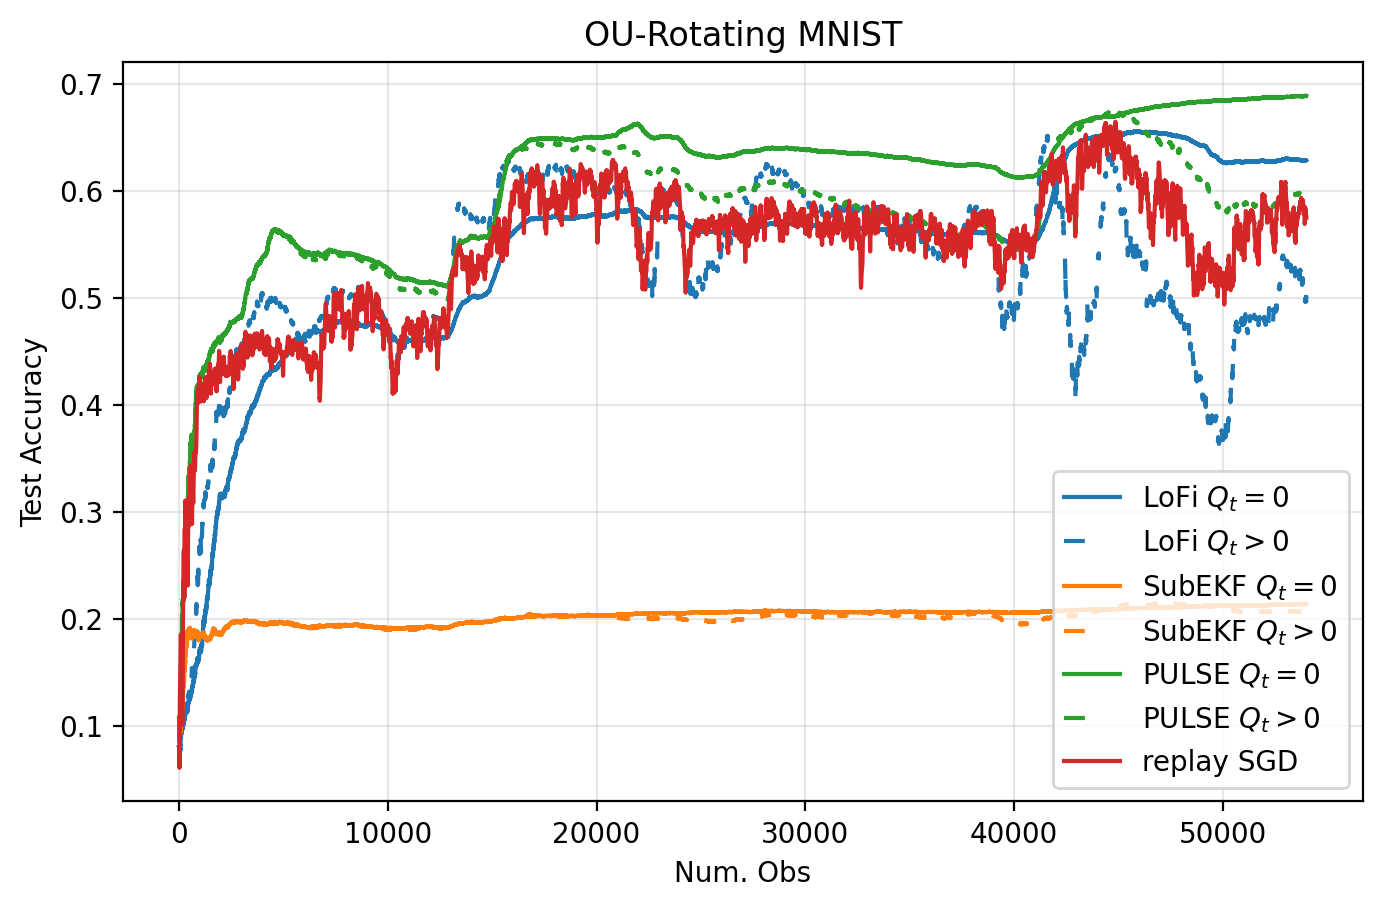

In [82]:
linestyle = (0, (5, 10)) # Loosely dashed
fig, ax = plt.subplots(figsize=(8, 4.8))
plt.plot(acc_lofi_0, label="LoFi $Q_t=0$", c="tab:blue")
plt.plot(acc_lofi_eps, label="LoFi $Q_t>0$", c="tab:blue", linestyle=linestyle)
plt.plot(acc_subekf_0, label="SubEKF $Q_t=0$", c="tab:orange")
plt.plot(acc_subekf_eps, label="SubEKF $Q_t>0$", c="tab:orange", linestyle=linestyle)
plt.plot(acc_pulse_0, label="PULSE $Q_t=0$", c="tab:green")
plt.plot(acc_pulse_eps, label="PULSE $Q_t>0$", c="tab:green", linestyle=linestyle)
plt.plot(acc_replaysgd, label="replay SGD", c="tab:red")
plt.legend(loc="lower right")
plt.xlabel("Num. Obs")
plt.ylabel("Test Accuracy")
plt.title("OU-Rotating MNIST")
plt.grid(alpha=0.3)

Text(0.5, 0, 'Observation num.')

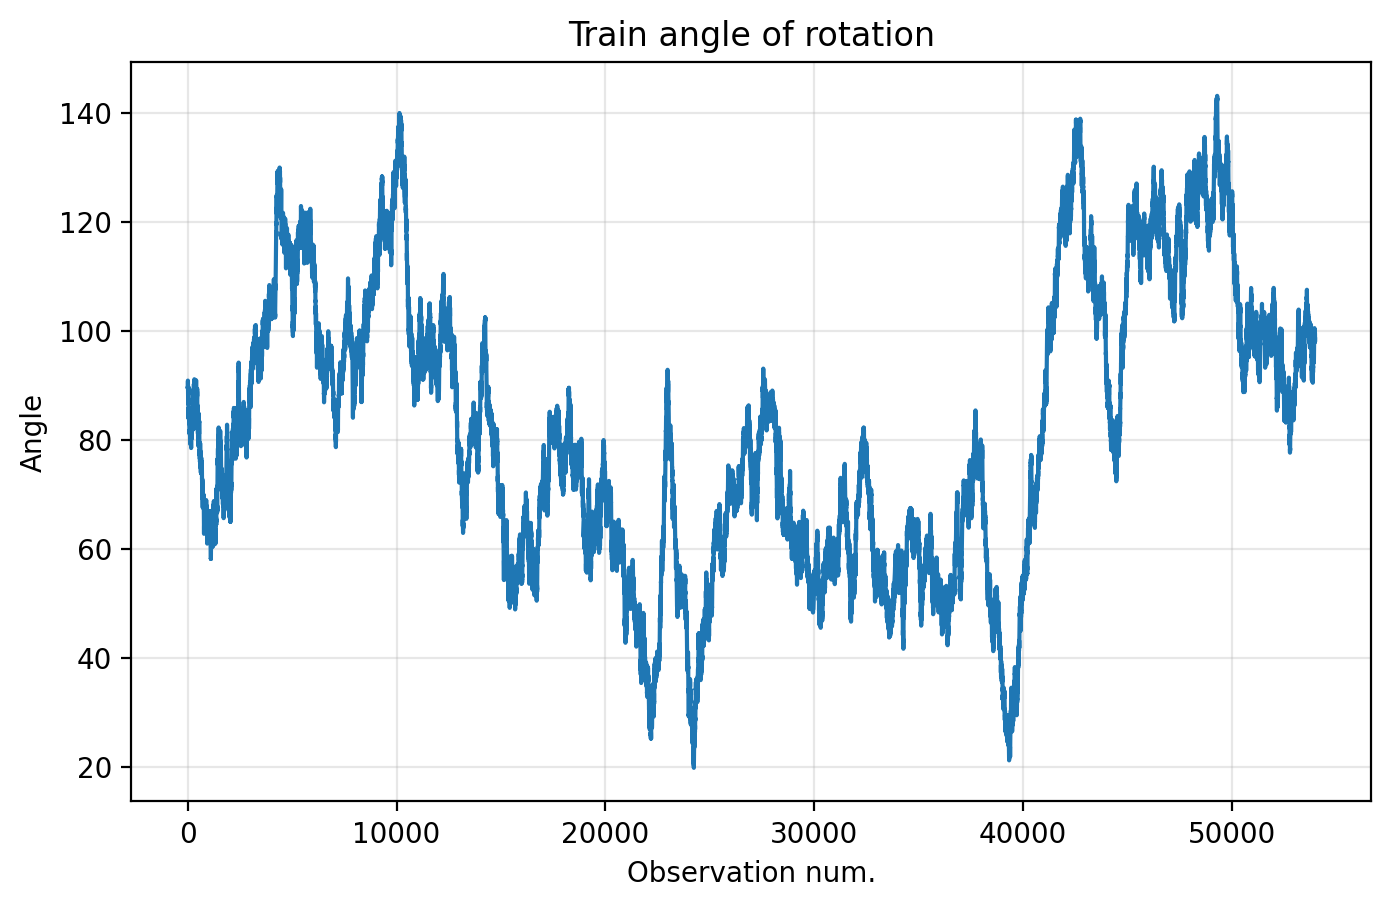

In [83]:
fig, ax = plt.subplots(figsize=(8, 4.8))
plt.plot(angles_train)
plt.grid(alpha=0.3)
plt.title("Train angle of rotation")
plt.ylabel("Angle")
plt.xlabel("Observation num.")